<h1><b>인공지능개론 5주차 과제(MNIST DL)</b></h1>
<p>컴퓨터공학과 202136038 조성준</p>


---

<h2><b>0. 라이브러리 import(분류)</b></h2>

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# pytorch관련 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
from torchvision import datasets, transforms


<h2><b>1. 하이퍼 파라미터</b></h2>

In [21]:
batch_size = 64
learning_rate = 0.001
epochs = 5

<h2><b>2. 데이터 전처리  로딩</b></h2>

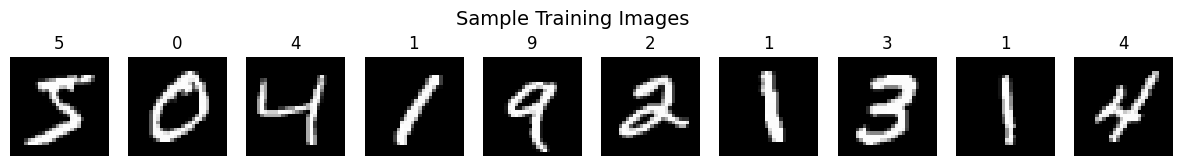

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 255] → [0, 1]
    transforms.Lambda(lambda x: x.view(-1))  # 28x28 → 784 (Flatten)
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 학습 이미지 10개 시각화
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    image, label = train_dataset[i]
    image = image.view(28, 28)  # Tensor: 1x28x28 → 28x28
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(str(label))
    axes[i].axis('off')
plt.suptitle("Sample Training Images", fontsize=14)
plt.show()

<h2><b>3. DNN 모델 정의</b></h2>

In [23]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

model = DNN()

<h2><b>4. 손실 함수와 옵티마이저</b></h2>

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

<h2><b>5. 학습 루프</b></h2>

In [25]:
epoch_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.2867
Epoch 2, Loss: 0.1102
Epoch 3, Loss: 0.0704
Epoch 4, Loss: 0.0521
Epoch 5, Loss: 0.0397


<h2><b>6. 테스트 정확도 측정</b></h2>

In [26]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        output = model(x)
        _, predicted = torch.max(output.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.00%


<h2><b>7. 학습곡선 시각화</b></h2>

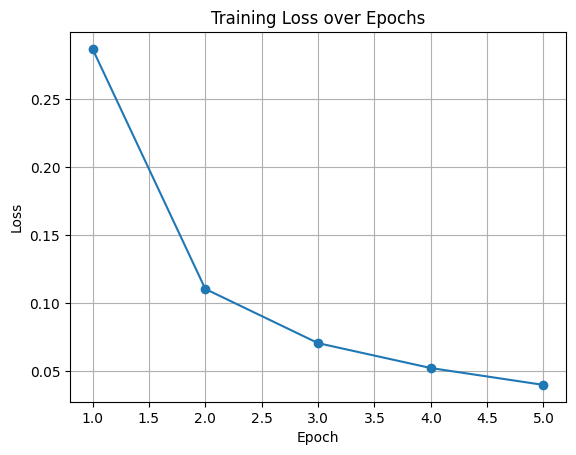

In [27]:
# Loss 시각화
plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

<h2><b>8. 혼동 행렬 및 리포트</b></h2>

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.97      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



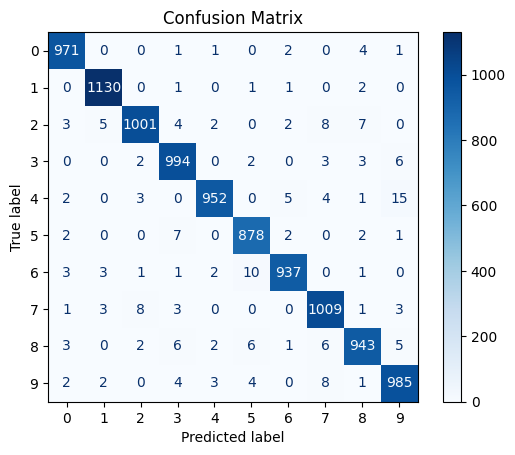

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 예측값 수집
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y.tolist())
        y_pred.extend(predicted.tolist())

# 리포트 출력
print(classification_report(y_true, y_pred))

# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


<h2><b>9. 예측 결과 시각화</b></h2>

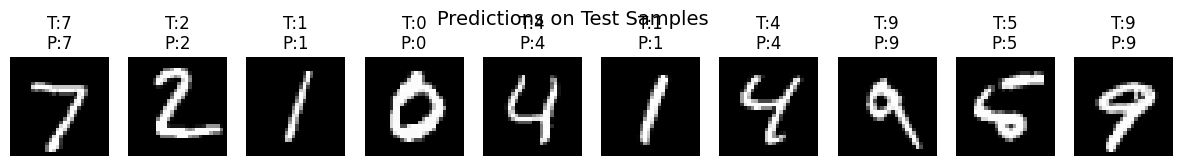

In [29]:
# 테스트 데이터 중 일부 예측 결과 시각화
samples = 10
fig, axes = plt.subplots(1, samples, figsize=(15, 2))
model.eval()

for i in range(samples):
    image, label = test_dataset[i]
    input_img = image.view(-1, 784)  # Flatten
    with torch.no_grad():
        output = model(input_img)
        predicted = torch.argmax(output).item()

    axes[i].imshow(image.view(28, 28), cmap='gray')
    axes[i].set_title(f"T:{label}\nP:{predicted}")
    axes[i].axis('off')

plt.suptitle("Predictions on Test Samples", fontsize=14)
plt.show()
